In [2]:
import numpy as np
import copy
import cv2
import h5py 
import scipy
from PIL import Image 
from scipy import ndimage
import matplotlib.pyplot as plt

- [Cat detection](http://localhost:8889/notebooks/projects/machine_learning/Neural%20networks.ipynb#Cat-detection)

# Cat detection

In [3]:
def load_dataset():
    train_ds = h5py.File('./DATA/train_catvnoncat.h5', 'r')
    train_set_x = np.array(train_ds['train_set_x'][:])
    train_set_y = np.array(train_ds['train_set_y'][:])
    
    test_ds = h5py.File('./DATA/test_catvnoncat.h5', 'r')
    test_set_x = np.array(test_ds['test_set_x'][:])
    test_set_y = np.array(test_ds['test_set_y'][:])
    
    classes = np.array(test_ds['list_classes'][:])
    
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    return train_set_x, train_set_y, test_set_x, test_set_y, classes

In [4]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

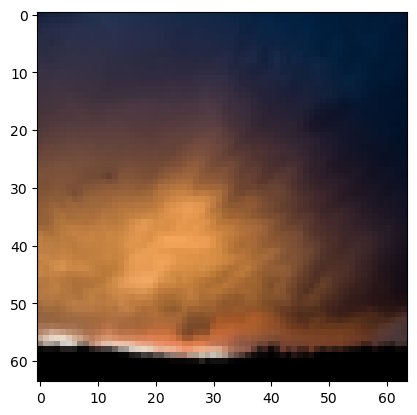

In [5]:
plt.imshow(train_set_x_orig[0])

In [6]:
print('shape: ', train_set_x_orig.shape)
print('image size: ', train_set_x_orig.shape[1:3])
print('train count: ', train_set_x_orig.shape[0])
print('test count: ', test_set_x_orig.shape[0])
classes

shape:  (209, 64, 64, 3)
image size:  (64, 64)
train count:  209
test count:  50


array([b'non-cat', b'cat'], dtype='|S7')

In [7]:
index = 2
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [1], it's a 'cat' picture.


In [8]:
train_set_y

array([[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [9]:
# A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b ∗ c ∗ d, a) is to use:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [10]:
# To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.
# One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. 
# But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

In [11]:
train_set_x

array([[0.06666667, 0.76862745, 0.32156863, ..., 0.56078431, 0.08627451,
        0.03137255],
       [0.12156863, 0.75294118, 0.27843137, ..., 0.60784314, 0.09411765,
        0.10980392],
       [0.21960784, 0.74509804, 0.26666667, ..., 0.64705882, 0.09019608,
        0.20784314],
       ...,
       [0.        , 0.32156863, 0.54117647, ..., 0.33333333, 0.01568627,
        0.        ],
       [0.        , 0.31372549, 0.55294118, ..., 0.41960784, 0.01960784,
        0.        ],
       [0.        , 0.31764706, 0.55686275, ..., 0.58431373, 0.        ,
        0.        ]])

In [12]:
train_set_x_flatten

array([[ 17, 196,  82, ..., 143,  22,   8],
       [ 31, 192,  71, ..., 155,  24,  28],
       [ 56, 190,  68, ..., 165,  23,  53],
       ...,
       [  0,  82, 138, ...,  85,   4,   0],
       [  0,  80, 141, ..., 107,   5,   0],
       [  0,  81, 142, ..., 149,   0,   0]], dtype=uint8)

In [13]:
def sigmoid(z):
    """
    Compute the sigmoid of z
    """
    return  1 / (1 + np.exp(-z))

In [14]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    w = np.zeros((dim, 1))
    b = 0.0

    return w, b

In [15]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    grads -- dictionary containing the gradients of the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    cost -- negative log-likelihood cost for logistic regression
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    n = X.shape[1]
    
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -1/n * (np.dot(Y,np.log(A).T) + np.dot((1-Y), np.log(1 - A).T)) 
    dw = 1/n * np.dot(X, (A-Y).T)
    db = 1/n * np.sum(A - Y)
    cost = np.squeeze(np.array(cost))

    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost


In [16]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs


In [17]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    n = X.shape[1]
    Y_prediction = np.zeros((1, n))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0, i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
        
    return Y_prediction


In [18]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Gradient descent 
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "params"
    w = params["w"]
    b = params["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d


In [19]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


[array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[0.]]),
 array([[1.]]),
 array([[0.]]),
 array([[1.]])]

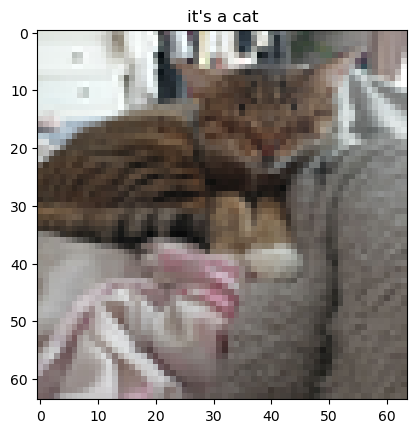

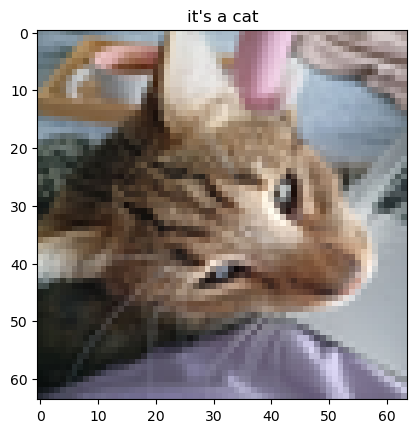

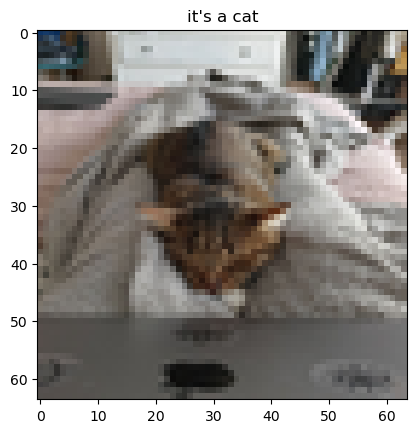

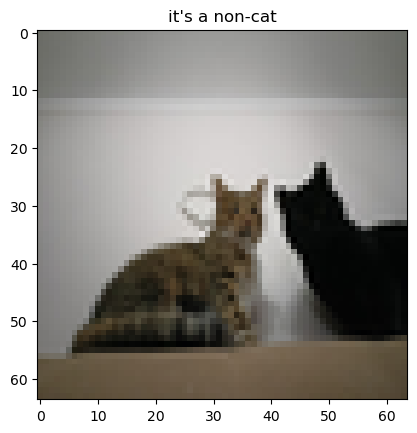

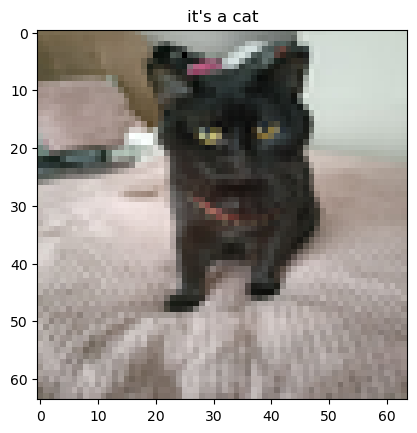

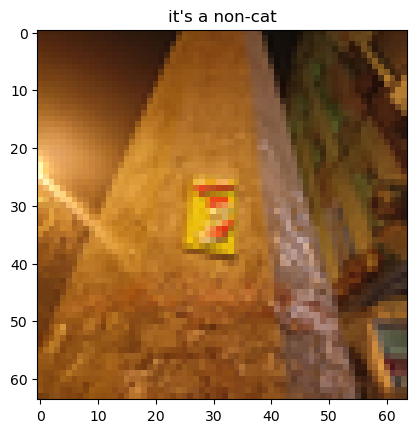

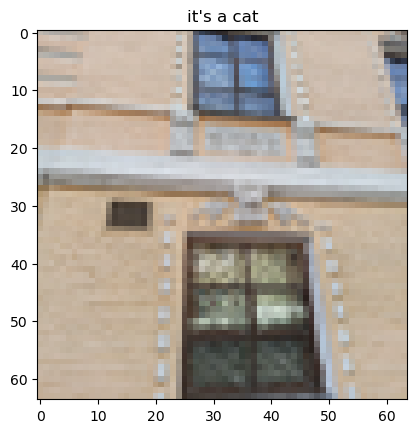

In [20]:
# Preprocess the image to fit your algorithm
num_px = train_set_x.shape[1]

images_to_check = [
    'photo_2024-01-06_17-55-28.jpg',
    'photo_2024-01-06_17-55-29.jpg',
    'photo_2024-01-06_17-55-31.jpg',
    'photo_2024-01-06_17-55-34.jpg',
    'photo_2024-01-06_17-55-37.jpg',
    'photo_2024-01-06_17-58-07.jpg',
    'photo_2024-01-06_17-58-08.jpg'
]
preds = []

for index, my_image in enumerate(images_to_check):
    fname = "images/kitties/" + my_image
    img = Image.open(fname)
    img = img.resize((64, 64), Image.LANCZOS)
    plt.figure()
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    flatten_image = img.reshape(img.shape[0], -1).T
    image = flatten_image / 255
    my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)
    preds.append(my_predicted_image)
    plt.title("it's a " + classes[my_predicted_image[0][0].astype(int)].decode("utf-8"))

preds

array([[0.]])

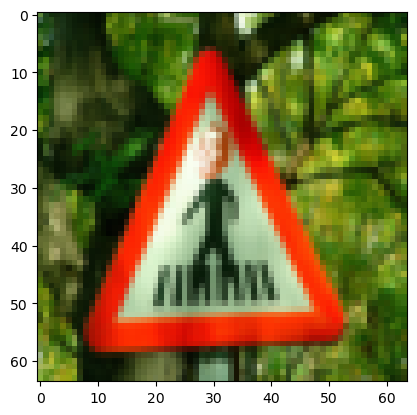

In [21]:
num_px = train_set_x.shape[1]

img = test_set_x_orig[14]
# img = img.resize((64, 64), Image.LANCZOS)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
flatten_image = img.reshape(img.shape[0], -1).T
image = flatten_image / 255
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)
my_predicted_image

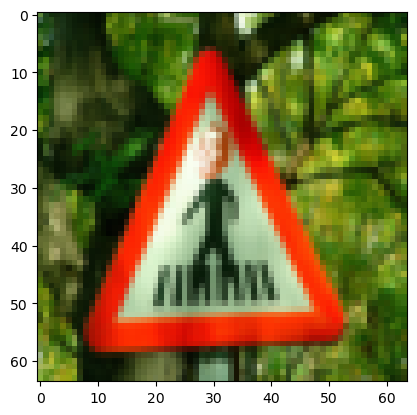

In [22]:
# reverse check of image
result = image * 255
result = result.reshape(1, 64, 64, 3)
result.shape
result = np.squeeze(result, axis=0).round(0).astype(int)
result.shape
result
plt.imshow(result)

# X

In [23]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    

def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

In [25]:
X, Y = load_planar_dataset()

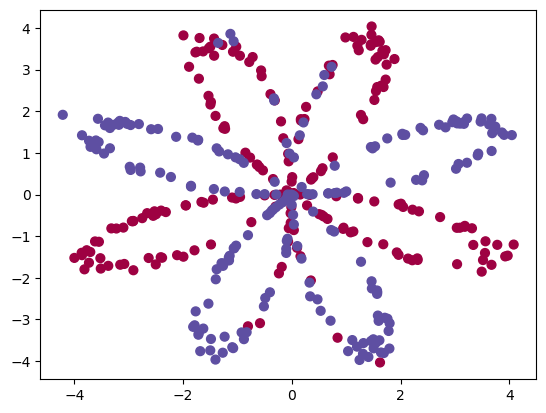

In [26]:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
shape_X = X.shape
shape_Y = Y.shape
m = np.dot(shape_X, shape_Y)

In [27]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV()

Text(0.5, 1.0, 'Logistic Regression')

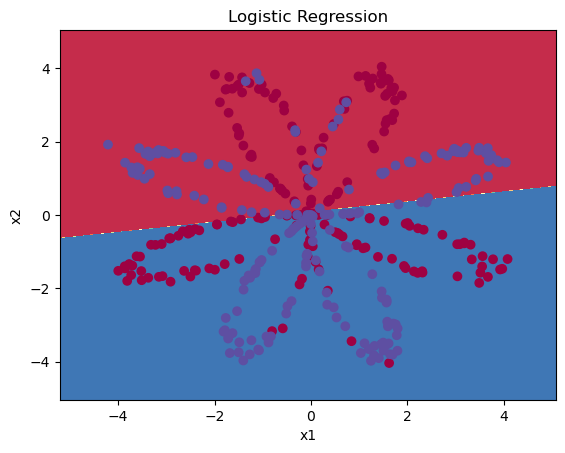

In [32]:
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

In [29]:
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


# Here new block

 Neural Network model  

The general methodology to build a Neural Network is to:
1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
2. Initialize the model's parameters
3. Loop:
    - Implement forward propagation
    - Compute loss
    - Implement backward propagation to get the gradients
    - Update parameters (gradient descent)

In [33]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    
    return (n_x, n_h, n_y)


In [34]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
        W1 -- weight matrix of shape (n_h, n_x)
        b1 -- bias vector of shape (n_h, 1)
        W2 -- weight matrix of shape (n_y, n_h)
        b2 -- bias vector of shape (n_y, 1)
    """    

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters


In [35]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache


In [36]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of examples

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - 1/m * np.sum(logprobs)
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    
    return cost


In [37]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    A1 = cache['A1']
    A2 = cache['A2']
    
    dZ2 = A2 - Y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = np.multiply(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis = 1, keepdims = True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads


In [38]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
   
    W1 = copy.deepcopy(parameters["W1"])
    b1 = copy.deepcopy(parameters["b1"])
    W2 = copy.deepcopy(parameters["W2"])
    b2 = copy.deepcopy(parameters["b2"])
    
    dW1 = copy.deepcopy(grads["dW1"])
    db1 = copy.deepcopy(grads["db1"])
    dW2 = copy.deepcopy(grads["dW2"])
    db2 = copy.deepcopy(grads["db2"])
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters


In [39]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):
         
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters


In [40]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    
    return predictions


Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.258625
Cost after iteration 2000: 0.239334
Cost after iteration 3000: 0.230802
Cost after iteration 4000: 0.225528
Cost after iteration 5000: 0.221845
Cost after iteration 6000: 0.219094
Cost after iteration 7000: 0.220645
Cost after iteration 8000: 0.219404
Cost after iteration 9000: 0.218484
Accuracy: 90%


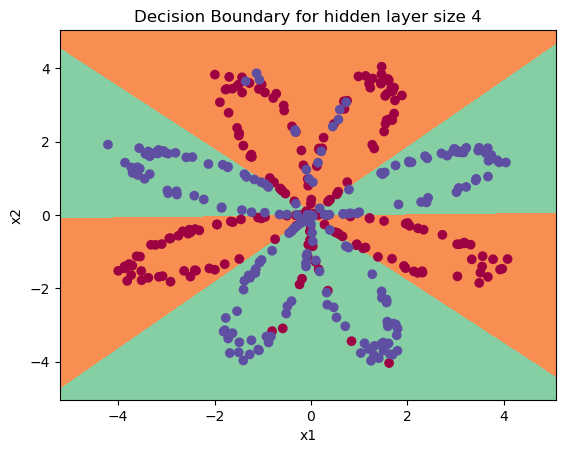

<Figure size 1600x3200 with 0 Axes>

In [41]:
# 
# Test the Model on the Planar Dataset
# 

# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5]

Accuracy for 1 hidden units: 86.5 %
Accuracy for 2 hidden units: 90.5 %
Accuracy for 3 hidden units: 99.0 %
Accuracy for 4 hidden units: 99.0 %
Accuracy for 5 hidden units: 99.0 %


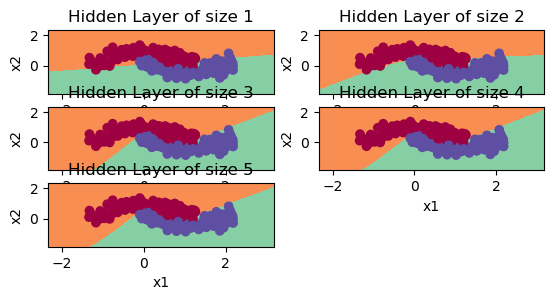

In [45]:
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

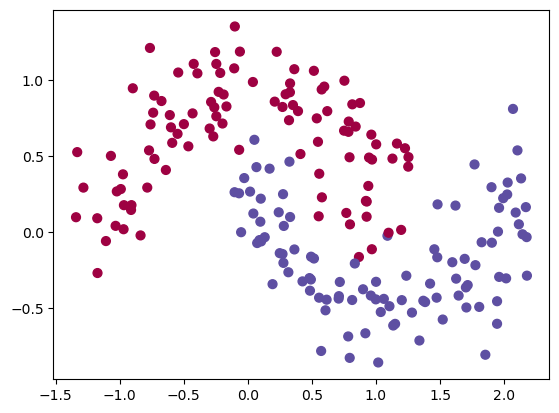

In [43]:
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)